## Classifying Movie Reviews
*A binary classification example*
### Loading the Dataset
Load the dataset and keep the 10.000 most frequently occurring words.
The loaded data is split 50/50 into train data and test data.

In [24]:
# for running on CPU only (Laptop)
import os
# (opt.) force CPU use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [31]:
from keras.datasets import imdb

# load data and split into training and test (50/50)
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

## decode and display single entry of dataset
# get word -> index mapping from dataset
word_index = imdb.get_word_index()
# reverse to get index -> word mapping
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# decode review
decoded_review = " ".join(reverse_word_index.get(i - 3, "?") for i in train_data[0])
#--- index offset because 0, 1, and 2 are reserved for "padding", "start of sequence" and "unknown"
print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

### Prepare the Data
Only Tensors can be fed into a neural network, therefore two options:
1. pad lists to same length and turn into tensor of shape (samples, word_indices) e.g. for *Embedding Layer*
2. encode lists into vectors of size 10.000 e.g. for *Dense Layer*
    - index list of [3, 5] turns into vector with all 0 except for position 3 & 5

In [32]:
import numpy as np

# function to turn list of indices into vector with indices set to 1 (default 0)
def vectorize_sequences(sequences, dimension=10000):
    # create matrix of size: number of sequences (reviews) X dimension of sequence (10.000)
    results = np.zeros((len(sequences), dimension))
    # set indices of sequence to 1
    for i, seq in enumerate(sequences):
        results[i, seq] = 1
    return results

# vectorize training and test data
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

# vectorize labels (already 1 = positive / 0 = negative)
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

### Building the Network
The network is proposed as:
+ 2 intermediate layers (Dense) with 16 hidden units & relu activations
+ 1 output layer (Dense) with 1 hidden unit & sigmoid activation

In [38]:
from keras import models, layers, optimizers, losses, metrics

# create sequential model to add layers
model = models.Sequential()
# add intermediate layers
model.add(layers.Dense(16, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(16, activation="relu"))
# add output layer
model.add(layers.Dense(1, activation="sigmoid"))

# compiling model with rmsprop optimizer & binary_crossentropy loss function
model.compile(
    # configure optimizer
    optimizer=optimizers.RMSprop(lr=0.001),
    # configure loss function
    loss=losses.binary_crossentropy,
    # configure metrics
    metrics=[metrics.binary_accuracy]
)

### Validate & Train Model
Monitoring accuracy on never before seen images during training, by setting apart validation set from the training data (10.000 entries)

In [39]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

## train network
history = model.fit(
    partial_x_train,
    partial_y_train,
    # train samples for 20 iterations (epochs)
    epochs=5,
    # train in batches of 512
    batch_size=512,
    # provide validation data
    validation_data=(x_val, y_val)
)
results = model.evaluate(x_test, y_test)
print(results)

Train on 15000 samples, validate on 10000 samples
Epoch 1/5
15000/15000 [==============================] - 3s 198us/step - loss: 0.5156 - binary_accuracy: 0.7803 - val_loss: 0.3926 - val_binary_accuracy: 0.8620
Epoch 2/5
15000/15000 [==============================] - 2s 163us/step - loss: 0.3023 - binary_accuracy: 0.9046 - val_loss: 0.3022 - val_binary_accuracy: 0.8877
Epoch 3/5
15000/15000 [==============================] - 2s 164us/step - loss: 0.2209 - binary_accuracy: 0.9291 - val_loss: 0.2772 - val_binary_accuracy: 0.8911
Epoch 4/5
15000/15000 [==============================] - 2s 163us/step - loss: 0.1732 - binary_accuracy: 0.9411 - val_loss: 0.2761 - val_binary_accuracy: 0.8906
Epoch 5/5
25000/25000 [==============================] - 4s 142us/step
[0.3024183147239685, 0.8802]


### visualize training history
Plotting training and validation loss.

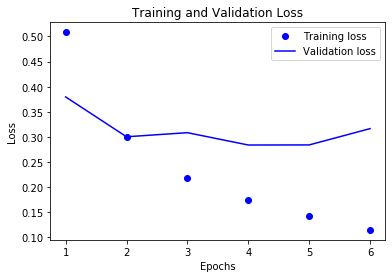

In [35]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

# plot training loss in blue, dotted
plt.plot(epochs, loss_values, "bo", label="Training loss")
# plot validation loss in blue, solid
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

Plotting training and validation accuracy.

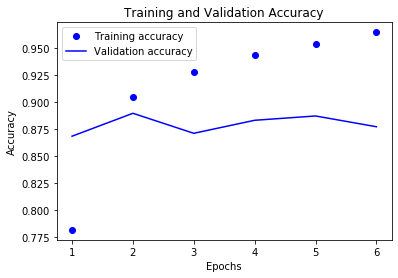

In [36]:
plt.clf()
acc_values = history_dict["binary_accuracy"]
val_acc_values = history_dict["val_binary_accuracy"]

# plot training accuracy in blue, dotted
plt.plot(epochs, acc_values, "bo", label="Training accuracy")
# plot validation accuracy in blue, solid
plt.plot(epochs, val_acc_values, "b", label="Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### Prediction of New Data

In [37]:
predictions = model.predict(x_test)
# print sample with prediction result
review_idx = np.random.randint(0, 25000-1)
review_pred = predictions[review_idx]
review_text = " ".join(reverse_word_index.get(i - 3, "?") for i in test_data[review_idx])

print("Review predicted " + str(review_pred[0]) + "% positive.")
print(review_text)

Review predicted 0.9869461% positive.
? in this approximately ? second thomas edison produced short we see ? moore performing the fuller choreographed ? dance in two different ? flowing ? br br moore was one of the bigger stars of the late victorian era she was featured in a number of edison company shorts including this one which was among the first ? films shown in london in ? br br fuller had actually ? the ? dance which moore performs here in ? as well as entire frames that are frequently hand ? in the film ? one of the more common symbolic devices of the silent era supposedly the moore films were popular enough to have to be frequently ? including the version available to us now may be a later version remake moore became even more popular when it was ? that she would appear naked at a private party at a restaurant in new york city she later went on to star as the gibson bathing girl in the ? ? in ? she appeared there until ? br br the short is notable for its framing of motion whi